In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import random
from heapq import heappush, heappop

In [2]:
from gridWorldEnvironment import GridWorld

In [3]:
# creating gridworld environment
gw = GridWorld(gamma = .9, theta = .5)

In [4]:
def state_action_value(env):
    q = dict()
    for state, action, next_state, reward in env.transitions:
        q[(state, action)] = np.random.normal()
    return q

In [5]:
def generate_greedy_policy(env, Q):
    pi = dict()
    for state in env.states:
        actions = []
        q_values = []
        prob = []
        
        for a in env.actions:
            actions.append(a)
            q_values.append(Q[state,a])   
        for i in range(len(q_values)):
            if i == np.argmax(q_values):
                prob.append(1)
            else:
                prob.append(0)       
                
        pi[state] = (actions, prob)
    return pi

In [6]:
def greedy(env, q, state):
    actions = env.actions
    action_values = []
    for action in actions:
        action_values.append(q[state, action])
    return actions[np.argmax(action_values)]

In [7]:
def e_greedy(env, e, q, state):
    actions = env.actions
    action_values = []
    prob = []
    for action in actions:
        action_values.append(q[(state, action)])
    for i in range(len(action_values)):
        if i == np.argmax(action_values):
            prob.append(1 - e + e/len(action_values))
        else:
            prob.append(e/len(action_values))
    return actions, prob


In [8]:
# e-greedy policy is an extension of e_greedy()
def generate_e_greedy_policy(env, e, Q):
    pi = dict()
    for state in env.states:
        pi[state] = e_greedy(env, e, Q, state)
    return pi

In [9]:
def prioritized_sweeping(env, epsilon, alpha, theta, num_iter, planning_steps):
    Q = state_action_value(env)
    pi = generate_e_greedy_policy(env, epsilon, Q)
    for _ in range(num_iter):
        current_state = np.random.choice(env.states)
        model={}
        pqueue = []
        while current_state != 0:
            current_state = np.random.choice(env.states)
            current_action = np.random.choice(pi[current_state][0], p = pi[current_state][1])
            next_state, reward = env.state_transition(current_state, current_action)
            if next_state==0:
                break            
            model[current_state, current_action] = (next_state, reward)           
            best_action = greedy(env, Q, next_state)    
            P=abs(reward + env.gamma * Q[next_state, best_action] - Q[current_state, current_action])          
            if P > theta:
                heappush(pqueue, (current_state, current_action))
                          
            for n in range(planning_steps):
                if not pqueue:
                    break
                state, action = heappop(pqueue)
                new_state, new_reward = model[state, action]
                
                new_best_action = greedy(env, Q, new_state) 
                Q[state, action] += alpha*(new_reward + env.gamma * Q[new_state, new_best_action] - Q[state, action])
                
                hat=[]
                for s_a, ns_r in model.items():
                    if ns_r[0]==state:
                        hat.append([s_a[0], s_a[1], ns_r[1]])
                        
                for item in hat:
                    reward_hat=item[2]
                    best_act= greedy(env, Q, state)
                    P=abs(reward_hat + env.gamma * Q[state, best_act] - Q[item[0], item[1]])
                    if P > theta:
                        heappush(pqueue, (item[0], item[1]))
    return Q

In [10]:
Q = prioritized_sweeping(gw, 0.2 ,0.1, 1e-03, 1000, 5)

In [11]:
pi_hat = generate_greedy_policy(gw, Q)

In [12]:
def show_policy(pi, env):
    temp = np.zeros(len(env.states) + 2)
    for s in env.states:
        a = pi_hat[s][0][np.argmax(pi_hat[s][1])]
        if a == "U":
            temp[s] = 0.25
        elif a == "D":
            temp[s] = 0.5
        elif a == "R":
            temp[s] = 0.75
        else:
            temp[s] = 1.0
            
    temp = temp.reshape(4,4)
    ax = seaborn.heatmap(temp, cmap = "prism", linecolor="#282828", cbar = False, linewidths = 0.1)
    plt.show()

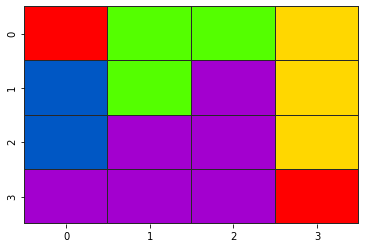

In [13]:
### RED = TERMINAL (0)
### GREEN = LEFT
### BLUE = UP
### PURPLE = RIGHT
### ORANGE = DOWN

show_policy(pi_hat, gw)